# Import libraries

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math  
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import yfinance as yf

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing

In [5]:
def load(symbol,start_date,end_date):
  df = yf.download(symbol, start=start_date, end=end_date)
  return df

In [6]:
def count(start_date,end_date):
  end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
  start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
  return (end_date_object-start_date_object)

In [ ]:
def plot(df):
  df_plot = df.copy()

  ncols = 2
  nrows = int(round(df_plot.shape[1] / ncols, 0))

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [7]:
def preprocess(df, seq_len=50):
  # Indexing Batches
  train_df = df.sort_values(by=['Date']).copy()

  # List of considered Features
  FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
              #, 'Month', 'Year', 'Adj Close'
            ]

  # print('FEATURE LIST')
  # print([f for f in FEATURES])

  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[FEATURES]

  # We add a prediction column and set dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']

  # Print the tail of the dataframe
  data_filtered_ext.tail()

    # Get the number of rows in the data
  nrows = data_filtered.shape[0]

  # Convert the data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print(np_data.shape)

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # Set the sequence length - this is the timeframe used to make a single prediction
  sequence_length = seq_len

  # Prediction Index
  index_Close = data.columns.get_loc("Close")

  # Split the training data into train and train data sets
  # As a first step, we get the number of rows to train the model on 80% of the data 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

  # Create the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # The RNN needs data with the format of [samples, time steps, features]
  # Here, we create N samples, sequence_length time steps per sample, and 6 features
  def partition_dataset(sequence_length, data):
      x, y = [], []
      data_len = data.shape[0]
      for i in range(sequence_length, data_len):
          x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
          y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
      
      # Convert the x and y to numpy arrays
      x = np.array(x)
      y = np.array(y)
      return x, y

  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data)
  x_test, y_test = partition_dataset(sequence_length, test_data)

  return FEATURES, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test

# Build RNN model

In [8]:
def create_RNN(hidden_units, input_shape, rnn_type, lr=0.001, loss="mse"):
  model = Sequential()
  if rnn_type == 'RNN':

    model.add(SimpleRNN(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(SimpleRNN(hidden_units, return_sequences=False))

  elif rnn_type == 'LSTM':

    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(LSTM(hidden_units, return_sequences=False))

  elif rnn_type == 'GRU':

    model.add(GRU(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(GRU(hidden_units, return_sequences=False))

  model.add(Dense(5))
  model.add(Dense(1))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=loss)  #loss='categorical_crossentropy'

  return model

In [9]:
def evaluate(model, x_train, y_train, x_test, y_test, scaler_pred, epoch=50, batch_size=16): #SimpleRNN_model | LSTM_model | GRU_model
  # Training the model
  epochs = epoch
  batch_size = batch_size
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_test, y_test)
                    )
                      
                      #callbacks=[early_stop])


  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  return history, y_pred, MAE, MAPE, MDAPE

In [10]:
def loss_plot(history, epochs):
  # Plot training & validation loss values
  fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  plt.title("Model loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
  plt.legend(["Train", "Test"], loc="upper left")
  plt.grid()
  plt.show()

In [11]:

def evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01" ):
  # The date from which on the date is displayed
  display_start_date = display_start_date

  # Add the difference between the valid and predicted prices
  train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
  valid.insert(1, "y_pred", y_pred, True)
  valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
  df_union = pd.concat([train, valid])

  # Zoom in to a closer timeframe
  df_union_zoom = df_union[df_union.index > display_start_date]

  # Create the lineplot
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("y_pred vs y_test")
  plt.ylabel(stockname, fontsize=18)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

  # Create the bar plot with the differences
  df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
  plt.legend()
  plt.show()

In [ ]:
# Illustrate weights across epochs
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
 

# Stock

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  222.320007  225.300003  221.580002  223.960007  223.960007   
2010-01-05  224.100006  228.000000  222.149994  226.559998  226.559998   
2010-01-06  225.119995  226.419998  218.149994  219.080002  219.080002   
2010-01-07  219.660004  220.500000  214.119995  216.130005  216.130005   
2010-01-08  213.100006  218.429993  212.130005  216.210007  216.210007   

             Volume  
Date                 
2010-01-04   863200  
2010-01-05   801100  
2010-01-06  1007800  
2010-01-07   768700  
2010-01-08   756600  
4704 days, 0:00:00


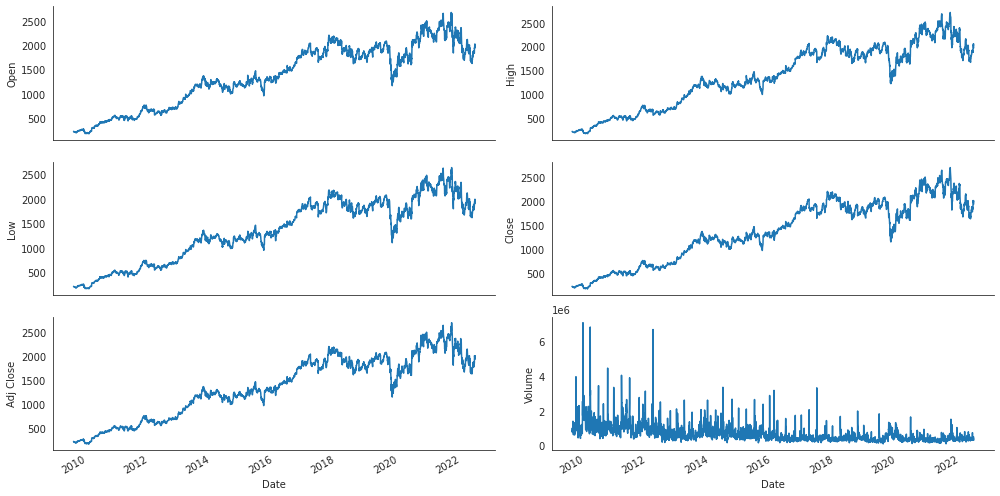

In [12]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Booking Holdings Inc'
symbol ='BKNG'

df = load(symbol,start_date, end_date)
print(df.head())

print(count(start_date, end_date))

plot(df)

# RNN

In [13]:
sequence_length = 50 #sliding_window 
FEATURES, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_train[1][sequence_length-1][index_Close])
# print(y_train[0])

n_neurons = x_train.shape[1] * x_train.shape[2]
# print(n_neurons, x_train.shape[1], x_train.shape[2])
SimpleRNN_model = create_RNN(hidden_units = n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='RNN', lr=0.01)


(3243, 5)


In [14]:
epoch=50

batch_size=16

history, y_pred, MAE, MAPE, MDAPE = evaluate(SimpleRNN_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
160/160 [==============================] - 14s 76ms/step - loss: 3.3368 - val_loss: 0.0070
Epoch 2/50
160/160 [==============================] - 22s 136ms/step - loss: 0.0070 - val_loss: 0.0288
Epoch 3/50
160/160 [==============================] - 12s 74ms/step - loss: 0.0039 - val_loss: 0.0338
Epoch 4/50
160/160 [==============================] - 13s 78ms/step - loss: 0.0059 - val_loss: 0.0181
Epoch 5/50
160/160 [==============================] - 12s 73ms/step - loss: 0.0054 - val_loss: 0.3120
Epoch 6/50
160/160 [==============================] - 11s 72ms/step - loss: 0.0488 - val_loss: 0.0606
Epoch 7/50
160/160 [==============================] - 13s 84ms/step - loss: 0.0066 - val_loss: 0.0126
Epoch 8/50
160/160 [==============================] - 16s 98ms/step - loss: 0.0044 - val_loss: 0.0160
Epoch 9/50
160/160 [==============================] - 12s 73ms/step - loss: 0.0057 - val_loss: 0.0156
Epoch 10/50
160/160 [==============================] - 12s 73ms/step - loss: 0.00

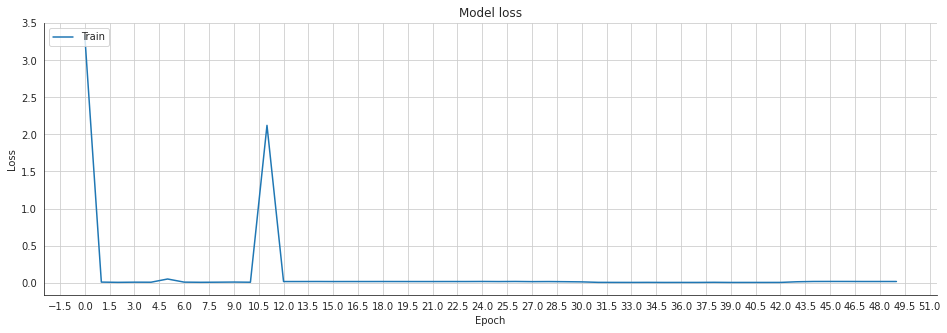

In [15]:
loss_plot(history, epochs=epoch)

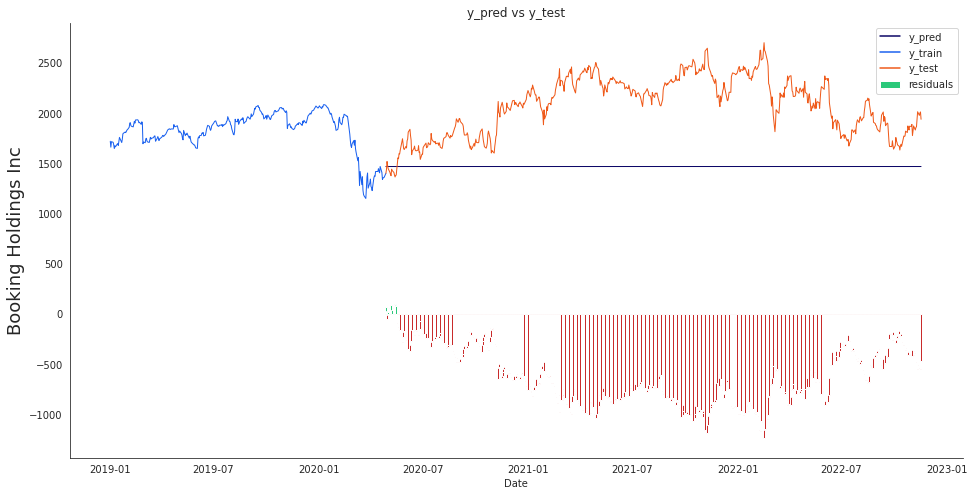

In [16]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01" )

# LSTM

In [17]:
sequence_length = 50 #sliding_window 
FEATURES, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_train[1][sequence_length-1][index_Close])
# print(y_train[0])

n_neurons = x_train.shape[1] * x_train.shape[2]
# print(n_neurons, x_train.shape[1], x_train.shape[2])
LSTM_model = create_RNN(hidden_units = n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='LSTM')
# print(LSTM_model)


(3243, 5)


In [18]:
epoch=50

batch_size=16

history, y_pred, MAE, MAPE, MDAPE = evaluate(LSTM_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)
# Median Absolute Error (MAE): 366.86
# Mean Absolute Percentage Error (MAPE): 2.81 %
# Median Absolute Percentage Error (MDAPE): 2.85 %


Epoch 1/50
160/160 [==============================] - 52s 302ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 2/50
160/160 [==============================] - 50s 312ms/step - loss: 3.0610e-04 - val_loss: 0.0012
Epoch 3/50
160/160 [==============================] - 53s 330ms/step - loss: 3.6344e-04 - val_loss: 0.0016
Epoch 4/50
160/160 [==============================] - 57s 358ms/step - loss: 2.8620e-04 - val_loss: 0.0016
Epoch 5/50
160/160 [==============================] - 55s 342ms/step - loss: 2.7287e-04 - val_loss: 0.0157
Epoch 6/50
160/160 [==============================] - 57s 359ms/step - loss: 6.6716e-04 - val_loss: 0.0011
Epoch 7/50
160/160 [==============================] - 59s 366ms/step - loss: 2.3945e-04 - val_loss: 8.7961e-04
Epoch 8/50
160/160 [==============================] - 66s 414ms/step - loss: 2.1172e-04 - val_loss: 9.7712e-04
Epoch 9/50
160/160 [==============================] - 68s 424ms/step - loss: 1.9708e-04 - val_loss: 8.3308e-04
Epoch 10/50
160/160 [========

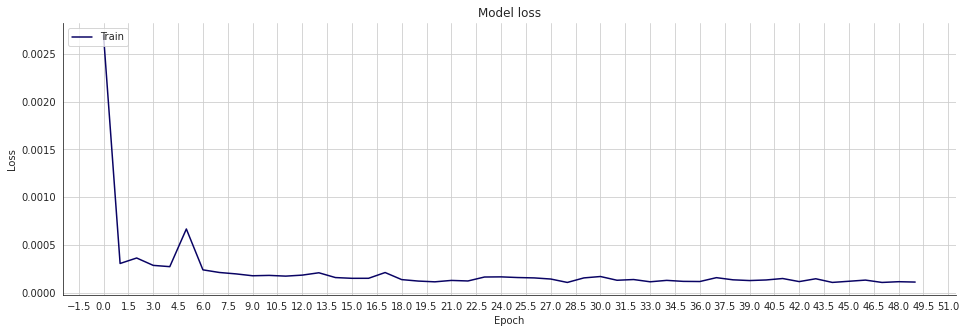

In [19]:
loss_plot(history, epochs=epoch)

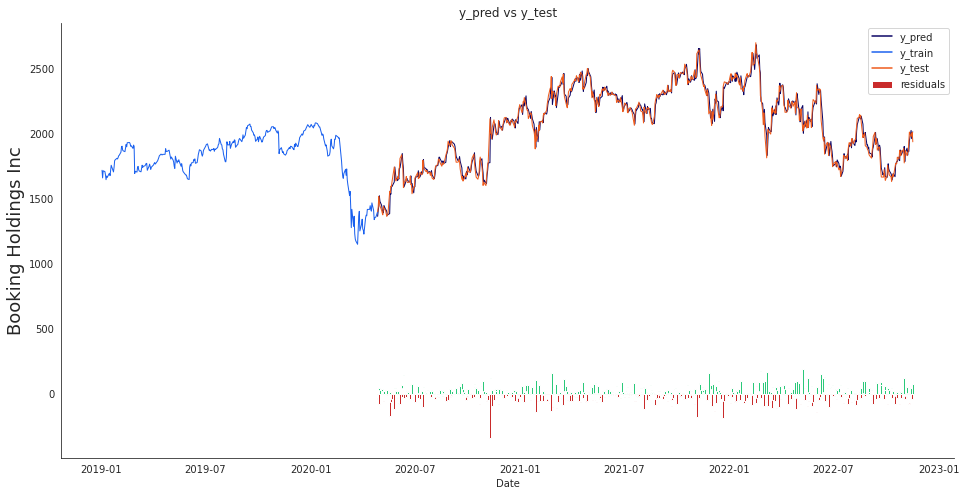

In [20]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01" )

# GRU

In [21]:
sequence_length = 50 #sliding_window 
FEATURES, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_train[1][sequence_length-1][index_Close])
# print(y_train[0])

n_neurons = x_train.shape[1] * x_train.shape[2]
# print(n_neurons, x_train.shape[1], x_train.shape[2])
GRU_model = create_RNN(hidden_units = n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='GRU', lr=0.01)


(3243, 5)


In [22]:
epoch=50

batch_size=16

history, y_pred, MAE, MAPE, MDAPE = evaluate(GRU_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
160/160 [==============================] - 46s 256ms/step - loss: 0.1622 - val_loss: 0.0035
Epoch 2/50
160/160 [==============================] - 44s 273ms/step - loss: 4.4382e-04 - val_loss: 0.0019
Epoch 3/50
160/160 [==============================] - 44s 272ms/step - loss: 4.4051e-04 - val_loss: 0.0038
Epoch 4/50
160/160 [==============================] - 46s 287ms/step - loss: 3.1639e-04 - val_loss: 0.0015
Epoch 5/50
160/160 [==============================] - 43s 268ms/step - loss: 3.0357e-04 - val_loss: 0.0409
Epoch 6/50
160/160 [==============================] - 43s 272ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 7/50
160/160 [==============================] - 45s 279ms/step - loss: 3.4491e-04 - val_loss: 7.4109e-04
Epoch 8/50
160/160 [==============================] - 44s 276ms/step - loss: 2.1376e-04 - val_loss: 8.6699e-04
Epoch 9/50
160/160 [==============================] - 46s 285ms/step - loss: 2.2914e-04 - val_loss: 0.0013
Epoch 10/50
160/160 [================

In [30]:
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

    
  def plotweight(capture_cb):
      "Plot the weights' mean and s.d. across epochs"
      fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
      ax[0].set_title("Mean weight")
      for key in capture_cb.weights[0]:
          ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
      ax[0].legend()
      ax[1].set_title("S.D.")
      for key in capture_cb.weights[0]:
          ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
      ax[1].legend()
      plt.show()
      
  plotweight(capture_cb)
    

In [33]:
# for below examples
grads = get_rnn_gradients(GRU_model, x_test, y_test, layer_idx=1) # return_sequences=True
grads = get_rnn_gradients(GRU_model, x_test, y_test, layer_idx=2) # return_sequences=False

UnboundLocalError: ignored

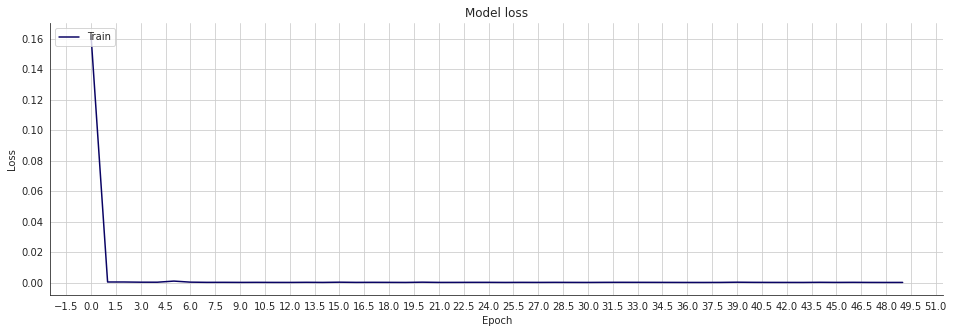

In [23]:
loss_plot(history, epochs=epoch)

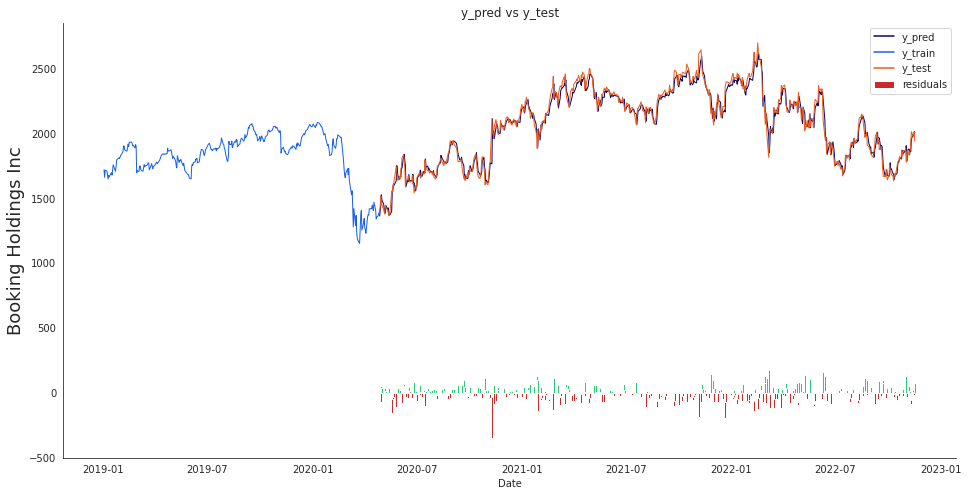

In [24]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01" )

# Predict Next Day


In [72]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = LSTM_model.predict(np.array(X_test_new)) #try different model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


1/1 [==============================] - 0s 23ms/step
The close price for NASDAQ at 2021-05-13 was 13031.68
The predicted close price is 12604.6201171875 (-3.39%)


In [11]:
red_price_scaled = SimpleRNN_model.predict(np.array(X_test_new)) #try different model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
